## Curve fitting example with Covalent

To use this notebook, it is recommended to run everything in a clean `conda` environment. The environment can be created by using the provided `environment.yml` file at the root level.

### Create environment

```bash
conda env create --file environment.yml
```


### Start Covalent

```bash
covalent start --ignore-migrations
```

To for more verbose logging, `covalent` can be started in `DEBUG` mode

```bash
covalent start -d --ignore-migrations
```

In [1]:
import numpy as np
import covalent as ct
import matplotlib.pyplot as plt

### Raw code

```python
x = [1, 2, 3, 9]
y = [1, 4, 1, 3]
```

### Fit
```python
fit = np.polyfit(x, y, 3)
xnew = np.linspace(x[0], x[-1], 50)
ynew = fit(xnew)
```


# plot
```python
fig, ax = plt.subplots()
plt.plot(x, y, 'o', xnew, ynew)
plt.xlim(x[0]-1, x[-1]+1)
```

### Functionalize the code (structured)

In [28]:
def fit_xy(x, y):
    z = np.polyfit(x, y, 3)
    return np.poly1d(z)

def plot_fit(x, y, xnew, fit):
    ynew = fit(xnew)
    fig, ax = plt.subplots()
    plt.plot(x, y, 'o')
    plt.plot(xnew, ynew, '-')
    plt.xlim([x[0]-1, x[-1]+1])
    return ax

def exp(x, y):
    xnew = np.linspace(x[0], x[-1], 50)
    fit = fit_xy(x=x, y=y)
    return plot_fit(x=x, y=y, xnew=xnew, fit=fit)

## Covalentify workflow

### Make `fit_xy` electron

In [38]:
@ct.electron
def fit_xy(x, y):
   z = np.polyfit(x, y, 10)
   return np.poly1d(z)

### Make an electron to plot the results

In [39]:
@ct.electron
def plot_fit(x, y, xnew, fit):
   ynew = fit(xnew)
   fig, ax = plt.subplots()
   plt.plot(x, y, 'o')
   plt.plot(xnew, ynew, '-')
   plt.xlim([x[0]-1, x[-1]+1])
   return ax

### Create lattice for curve fitting (workflow)

In [44]:
@ct.lattice
def exp(x, y):
   xnew = np.linspace(x[0], x[-1], 100)
   fit = fit_xy(x=x, y=y)
   return plot_fit(x=x, y=y, xnew=xnew, fit=fit)

### Dispatch workflow to covalent server (localhost:48008)

In [45]:
x = np.arange(10)
y = np.random.random(10)
dispatch_id = ct.dispatch(exp)(x = x, y = y)
print(dispatch_id)

eef84f8f-470c-449e-a145-1e36201fe488


[Covalent Server UI](http://localhost:48008)

### Curve fitting workflow

![Curve fitting](./assets/curve_fitting.png)

AxesSubplot(0.125,0.11;0.775x0.77)


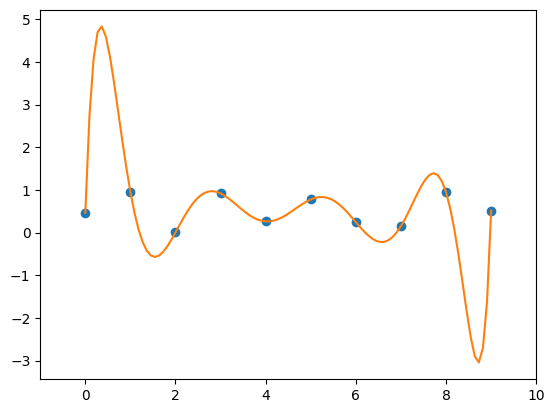

In [58]:
result = ct.get_result(dispatch_id=dispatch_id, wait=True)
print(result.result)